# FIT5202 Assignment 2A : Building Models for eCommerce Fraud Detection

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells if needed.

# Library

In [1]:
# Spark and PySpark imports
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, FloatType, 
    TimestampType, BooleanType, DoubleType
)
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, when, count, sum, min, max, mean, hour, expr, udf
)

# PySpark MLlib imports
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.functions import vector_to_array

# Plotting and metrics imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc

import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Spark SQL usage is discouraged, and you can only use pandas to format results. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 16MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is acceptable.)  (2%)

In [2]:
# Create a SparkConf object and configure the Spark app
conf = SparkConf().setAppName("Assignment 2A")\
        .setMaster("local[*]") \
        .set("spark.executor.memory", "4g") \
        .set("spark.driver.memory", "4g")\
        .set("spark.sql.files.maxPartitionBytes", "16MB") 

# Create the SparkSession with the specified configurations
spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()



1.1.2 Write code to define the schemas for the category, customer, product, browsing behaviour and transaction datasets, following the data types suggested in the metadata file. (3%)

In [3]:
# Define the schema for the customer dataset
customer_schema = StructType([
    StructField("customer_id", FloatType(), False),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", TimestampType(), True),
    StructField("first_join_date", TimestampType(), True)
])

# Define the schema for the category dataset
category_schema = StructType([
    StructField("category_id", FloatType(), False),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])

# Define the schema for the browsing behaviour dataset
browsing_behaviour_schema = StructType([
    StructField("session_id", StringType(), False),
    StructField("event_type", StringType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("device_type", StringType(), True)
])

# Define the schema for the product dataset
product_schema = StructType([
    StructField("id", StringType(), False),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", FloatType(), True)
])

# Define the schema for the transaction dataset
transaction_schema = StructType([
    StructField("created_at", TimestampType(), True),
    StructField("customer_id", FloatType(), True), 
    StructField("transaction_id", StringType(), False),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", FloatType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", FloatType(), True),
    StructField("shipment_location_lat", FloatType(), True),
    StructField("shipment_location_long", FloatType(), True),
    StructField("total_amount", FloatType(), True),
    StructField("clear_payment", BooleanType(), True)
])

# Define the schema for the customer session dataset
customer_session_schema = StructType([
    StructField("session_id", StringType(), False),
    StructField("customer_id", FloatType(), False)  
])

# Define the schema for the fraud transaction dataset
fraud_transaction_schema = StructType([
    StructField("transaction_id", StringType(), False),
    StructField("is_fraud", BooleanType(), False)
])

1.1.3 Using predefined schemas, write code to load the CSV files into separate data frames. Print the schemas of all data frames. (2%)

In [4]:
# Example usage to create DataFrames with the defined schemas
df_category = spark.read.csv("category.csv", schema=category_schema, header = True)
df_customer = spark.read.csv("customer.csv", schema=customer_schema, header = True)
df_product = spark.read.csv("product.csv", schema=product_schema, header = True)
df_browsing_behaviour = spark.read.csv("browsing_behaviour.csv", schema=browsing_behaviour_schema, header = True)
df_transactions = spark.read.csv("transactions.csv", schema=transaction_schema, header = True)
df_fraud_transaction = spark.read.csv("fraud_transaction.csv", schema=fraud_transaction_schema, header = True)
df_customer_session = spark.read.csv("customer_session.csv", schema=customer_session_schema, header = True)

In [5]:
# Print the schema of each DataFrame
print("Schema of df_category:")
df_category.printSchema()

print("\nSchema of df_customer:")
df_customer.printSchema()

print("\nSchema of df_product:")
df_product.printSchema()

print("\nSchema of df_browsing_behaviour:")
df_browsing_behaviour.printSchema()

print("\nSchema of df_transactions:")
df_transactions.printSchema()

print("\nSchema of df_fraud_transaction:")
df_fraud_transaction.printSchema()

print("\nSchema of df_customer_session:")
df_customer_session.printSchema()

Schema of df_category:
root
 |-- category_id: float (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)


Schema of df_customer:
root
 |-- customer_id: float (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: timestamp (nullable = true)
 |-- first_join_date: timestamp (nullable = true)


Schema of df_product:
root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- usage: string (nullable = true)
 |-- productDisplayName: string (nullable = true)
 |-- category_id: float (nullable = true)


Schema of df_browsing_behaviour:
root
 |-- session_id: string (nullable = true)
 |-- event_

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the browsing behaviour dataset, there are 10 types of events:  
VC(Viewing Category), VI(Viewing Item), VP(Viewing Promotion), AP(Add Promotion), CL(Click on a product/category) , ATC(Add a product to Shopping Cart), CO(CheckOut), HP(View HomePage), SCR(Mouse Scrolling), SER(Search for a product/category)  
We categorise them into three different levels:  
L1(actions that are highly likely lead to a purchase): AP, ATC, CO  
L2(actions may lead to purchase): VC, VP, VI, SER  
L3(not very important - just browsing):  SCR, HP, CL  
Perform the following tasks based on the loaded data frames and create a new data frame.  

1.2.1 For each transaction (linked to a browsing session), count the number of actions in each level and create 3 columns(L1_count, L2_count, L3_count).

In [6]:
# Define the action levels
L1_actions = {"AP", "ATC", "CO"}
L2_actions = {"VC", "VP", "VI", "SER"}
L3_actions = {"SCR", "HP", "CL"}

# Define the UDF to categorize actions into each level
def categorize_action(event_type):
    if event_type in L1_actions:
        return "L1"
    elif event_type in L2_actions:
        return "L2"
    elif event_type in L3_actions:
        return "L3"
    else:
        return "Unknown"

# Register the UDF
categorize_action_udf = udf(categorize_action, StringType())

# Apply the UDF to the browsing_behaviour DataFrame
df_browsing_behaviour = df_browsing_behaviour.withColumn("action_level", categorize_action_udf(df_browsing_behaviour["event_type"]))
df_browsing_behaviour.show(5)

+--------------------+----------+--------------------+--------------+-----------+------------+
|          session_id|event_type|          event_time|traffic_source|device_type|action_level|
+--------------------+----------+--------------------+--------------+-----------+------------+
|c9718135-8134-42b...|        AP|2020-12-17 07:04:...|        MOBILE|    Android|          L1|
|c9718135-8134-42b...|        CL|2020-12-06 09:07:...|        MOBILE|    Android|          L3|
|c9718135-8134-42b...|       SER|2020-12-17 07:12:...|        MOBILE|    Android|          L2|
|c9718135-8134-42b...|        CL|2021-01-08 02:28:...|        MOBILE|    Android|          L3|
|c9718135-8134-42b...|       ATC|2021-01-19 00:17:...|        MOBILE|    Android|          L1|
+--------------------+----------+--------------------+--------------+-----------+------------+
only showing top 5 rows



In [7]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, when, col

# Select distinct session_id from df_customer_session
df_distinct_sessions = df_customer_session.select("session_id").distinct()

# Perform the join on session_id from df_customer_session with df_browsing_behaviour to get registered users
df_browsing_behaviour_filter = df_browsing_behaviour.join(df_distinct_sessions, on=["session_id"], how="inner")


# Perform the aggregation with a pivot to get counts for each action_level
pivot_df = df_browsing_behaviour_filter.groupBy("session_id") \
                                       .pivot("action_level", ["L1", "L2", "L3"]) \
                                       .agg(count("event_type")) \
                                       .fillna(0)

# Rename the columns generated by pivot
pivot_df = pivot_df.withColumnRenamed("L1", "L1_count") \
                   .withColumnRenamed("L2", "L2_count") \
                   .withColumnRenamed("L3", "L3_count")

# Add counts for specific event types (ATC and SER)
atc_ser_df = df_browsing_behaviour_filter.groupBy("session_id") \
                                         .agg(
                                             count(when(col("event_type") == "ATC", True)).alias("ATC_count"),
                                             count(when(col("event_type") == "SER", True)).alias("SER_count")
                                         )

# Join the pivoted dataframe with the ATC and SER counts
feature_df = atc_ser_df.join(pivot_df, on="session_id", how="left")

# Show the final DataFrame
feature_df.show(5)



+--------------------+---------+---------+--------+--------+--------+
|          session_id|ATC_count|SER_count|L1_count|L2_count|L3_count|
+--------------------+---------+---------+--------+--------+--------+
|000130b9-07d1-437...|        1|        4|       2|      11|      34|
|0001434a-955b-41a...|        1|        0|       3|       1|       2|
|0003cf84-4bba-4d7...|        1|        2|       3|       6|      26|
|00049358-f228-48a...|        3|        0|       4|       0|       1|
|0004a700-7db4-412...|        3|        1|       4|       2|      10|
+--------------------+---------+---------+--------+--------+--------+
only showing top 5 rows



In [8]:
# Join feature_df with df_transactions by session_id and display it
feature_df = df_transactions.join(feature_df, "session_id", how="inner")

# Display the total number of rows
row_count = feature_df.count()
print(f"Total number of rows: {row_count}", '\n')

# Display required columns
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count" ).show(5)

Total number of rows: 657987 

+--------------------+--------+--------+--------+
|      transaction_id|L1_count|L2_count|L3_count|
+--------------------+--------+--------+--------+
|7063ddb3-a798-432...|       2|      11|      34|
|01944cc7-64af-40a...|       3|       1|       2|
|1ab6f843-9488-441...|       3|       6|      26|
|a2f2c3c1-339c-417...|       4|       0|       1|
|7c778b1d-088b-4e2...|       4|       2|      10|
+--------------------+--------+--------+--------+
only showing top 5 rows



1.2.2 Create two columns with a percentage ratio of L1 and L2 actions. (i.e. L1 ratio = L1/(L1+L2+L3) * 100%)

In [9]:
# Compute the total actions and the percentage ratios
feature_df = feature_df.withColumn("total_actions", col("L1_count") + col("L2_count") + col("L3_count")) \
                                                  .withColumn("L1_ratio", 
                                                                  (col("L1_count") / col("total_actions")) * 100) \
                                                  .withColumn("L2_ratio", 
                                                                  (col("L2_count") / col("total_actions")) * 100)

# Drop the total_actions column if no longer needed
feature_df = feature_df.drop("total_actions")

# Display the total number of rows
row_count = feature_df.count()
print(f"Total number of rows: {row_count}", '\n')

# Display required columns
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio").show(5)


Total number of rows: 657987 

+--------------------+--------+--------+--------+-----------------+------------------+
|      transaction_id|L1_count|L2_count|L3_count|         L1_ratio|          L2_ratio|
+--------------------+--------+--------+--------+-----------------+------------------+
|7063ddb3-a798-432...|       2|      11|      34| 4.25531914893617|23.404255319148938|
|01944cc7-64af-40a...|       3|       1|       2|             50.0|16.666666666666664|
|1ab6f843-9488-441...|       3|       6|      26|8.571428571428571|17.142857142857142|
|a2f2c3c1-339c-417...|       4|       0|       1|             80.0|               0.0|
|7c778b1d-088b-4e2...|       4|       2|      10|             25.0|              12.5|
+--------------------+--------+--------+--------+-----------------+------------------+
only showing top 5 rows



1.2.3 For each unique browsing session, based on event_time, extract the time of day as 4 groups: morning(6am-11:59am), afternoon(12pm-5:59pm), evening(6pm-11:59pm), night(12am-5:59am), add a column. (note: use medium time if a browsing session spans across different groups. For example, if a session starts at 10 am and ends at 1 pm, use 11:30 => (10+13)/2).

In [10]:
# Register UDF (User Defined Function) for time of day categorization
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Define the time of day groups
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

time_of_day_udf = udf(time_of_day, StringType())

# Extract the hour from `event_time` and categorize the time of day
df_browsing_behaviour = df_browsing_behaviour.withColumn("event_hour", hour(col("event_time"))) \
                                             .withColumn("time_of_day", time_of_day_udf(col("event_hour")))

# Compute min and max hour for each session to determine the span
df_session_times = df_browsing_behaviour.groupBy("session_id") \
                                        .agg(min("event_hour").alias("min_hour"), 
                                             max("event_hour").alias("max_hour"))

# Compute the medium time of day
df_session_times = df_session_times.withColumn("medium_hour", 
                                               (col("min_hour") + col("max_hour")) / 2) \
                                    .withColumn("time_of_day_medium", 
                                                when((col("medium_hour") >= 6) & (col("medium_hour") < 12), "morning")
                                                .when((col("medium_hour") >= 12) & (col("medium_hour") < 18), "afternoon")
                                                .when((col("medium_hour") >= 18) & (col("medium_hour") < 24), "evening")
                                                .otherwise("night"))

# Join the medium time of day back with the original DataFrame
feature_df = feature_df.join(df_session_times, on="session_id", how="left")

# Optionally drop columns that are no longer needed
feature_df = feature_df.drop("event_hour", "max_hour", "min_hour", "medium_hour")

# Display the total number of rows
row_count = feature_df.count()
print(f"Total number of rows: {row_count}", '\n')

# Display required columns
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "time_of_day_medium").show(5)

Total number of rows: 657987 

+--------------------+--------+--------+--------+-----------------+------------------+------------------+
|      transaction_id|L1_count|L2_count|L3_count|         L1_ratio|          L2_ratio|time_of_day_medium|
+--------------------+--------+--------+--------+-----------------+------------------+------------------+
|7063ddb3-a798-432...|       2|      11|      34| 4.25531914893617|23.404255319148938|           morning|
|01944cc7-64af-40a...|       3|       1|       2|             50.0|16.666666666666664|         afternoon|
|1ab6f843-9488-441...|       3|       6|      26|8.571428571428571|17.142857142857142|           morning|
|a2f2c3c1-339c-417...|       4|       0|       1|             80.0|               0.0|         afternoon|
|7c778b1d-088b-4e2...|       4|       2|      10|             25.0|              12.5|           evening|
+--------------------+--------+--------+--------+-----------------+------------------+------------------+
only showing to

1.2.4 Join data frames to find customer information and add columns to feature_df: gender, age, geolocation, first join year. (note: For some columns, you need to perform transformations. For age, keep the integer only by rounding.)

In [11]:
# Add current year column
current_year = F.year(F.current_date())

# Calculate age (round to integer) and first_join_year in the same step
df_customer = df_customer.withColumn("age", F.round(current_year - F.year("birthdate"))) \
                         .withColumn("first_join_year", F.year("first_join_date"))

# Join customer_df with df_transactions to add gender, age, geolocation, and first_join_year to feature_df
feature_df = feature_df.join(df_customer.select("customer_id", "gender", "age", "first_join_year"),
                                  on="customer_id", how="left")
# Display the total number of rows
row_count = feature_df.count()
print(f"Total number of rows: {row_count}", '\n')

# Display required columns
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "time_of_day_medium", "age", "shipment_location_lat", "shipment_location_long").show(5)

Total number of rows: 657987 

+--------------------+--------+--------+--------+-----------------+------------------+------------------+---+---------------------+----------------------+
|      transaction_id|L1_count|L2_count|L3_count|         L1_ratio|          L2_ratio|time_of_day_medium|age|shipment_location_lat|shipment_location_long|
+--------------------+--------+--------+--------+-----------------+------------------+------------------+---+---------------------+----------------------+
|7063ddb3-a798-432...|       2|      11|      34| 4.25531914893617|23.404255319148938|           morning| 27|            -6.606797|             107.89978|
|01944cc7-64af-40a...|       3|       1|       2|             50.0|16.666666666666664|         afternoon| 26|           -6.1313066|              106.7999|
|1ab6f843-9488-441...|       3|       6|      26|8.571428571428571|17.142857142857142|           morning| 31|            1.1844745|             113.82101|
|a2f2c3c1-339c-417...|       4|       0

1.2.5 Join data frames to find out the number of purchases the customer has made, add a column.

In [12]:
# Perform the aggregation by customer_id with payment_status conditions and L1, L2 counts and ratios
customer_trans_agg = feature_df.groupBy("customer_id").agg(
    # Transaction-related aggregations
    count("transaction_id").alias("num_trans"),
    
    # Count successful and failed transactions based on payment_status
    count(when(col("payment_status") == "Success", True)).alias("num_success_trans"),
    count(when(col("payment_status") == "Fail", True)).alias("num_failed_trans")
)

# Join the aggregation back to the original DataFrame
feature_df = feature_df.join(customer_trans_agg, on="customer_id", how="inner")

# Show the resulting DataFrame
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "time_of_day_medium", "age", "shipment_location_lat", "shipment_location_long", "num_trans").show(5)


+--------------------+--------+--------+--------+------------------+------------------+------------------+---+---------------------+----------------------+---------+
|      transaction_id|L1_count|L2_count|L3_count|          L1_ratio|          L2_ratio|time_of_day_medium|age|shipment_location_lat|shipment_location_long|num_trans|
+--------------------+--------+--------+--------+------------------+------------------+------------------+---+---------------------+----------------------+---------+
|525abd7b-1a95-441...|       2|       5|      16| 8.695652173913043| 21.73913043478261|           morning| 27|            -4.081251|             105.29492|       29|
|a52476b2-dba7-466...|       2|       3|       8|15.384615384615385|23.076923076923077|           morning| 27|            -6.130516|             106.74585|       44|
|517c0e05-11a2-4d2...|       4|       2|       2|              50.0|              25.0|           morning| 25|           -7.9832582|             110.54658|       39|
|65e

1.2.6 Attach the transaction labels for fraud/non-fraud.

In [13]:
# Join transactions with filtered merchants
feature_df = feature_df.join(df_fraud_transaction, "transaction_id", how="left")

# Fill NA values in is_fraud with False and cast the column to boolean
feature_df = feature_df.fillna({'is_fraud': False}) \
                       .withColumn("is_fraud", F.col("is_fraud").cast("boolean"))
# Display required columns
feature_df.select("transaction_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "time_of_day_medium", "age", "shipment_location_lat", "shipment_location_long", "num_trans", "is_fraud").show(5)

+--------------------+--------+--------+--------+------------------+------------------+------------------+---+---------------------+----------------------+---------+--------+
|      transaction_id|L1_count|L2_count|L3_count|          L1_ratio|          L2_ratio|time_of_day_medium|age|shipment_location_lat|shipment_location_long|num_trans|is_fraud|
+--------------------+--------+--------+--------+------------------+------------------+------------------+---+---------------------+----------------------+---------+--------+
|525abd7b-1a95-441...|       2|       5|      16| 8.695652173913043| 21.73913043478261|           morning| 27|            -4.081251|             105.29492|       29|   false|
|a52476b2-dba7-466...|       2|       3|       8|15.384615384615385|23.076923076923077|           morning| 27|            -6.130516|             106.74585|       44|   false|
|517c0e05-11a2-4d2...|       4|       2|       2|              50.0|              25.0|           morning| 25|           -7.9

In [14]:
feature_df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: float (nullable = true)
 |-- session_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- promo_amount: float (nullable = true)
 |-- promo_code: string (nullable = true)
 |-- shipment_fee: float (nullable = true)
 |-- shipment_location_lat: float (nullable = true)
 |-- shipment_location_long: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- clear_payment: boolean (nullable = true)
 |-- ATC_count: long (nullable = false)
 |-- SER_count: long (nullable = false)
 |-- L1_count: long (nullable = true)
 |-- L2_count: long (nullable = true)
 |-- L3_count: long (nullable = true)
 |-- L1_ratio: double (nullable = true)
 |-- L2_ratio: double (nullable = true)
 |-- time_of_day_medium: string (nullable = true)
 |-- gender: string (nullable = tr

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b) For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count. (3%)**

In [15]:
feature_stats = feature_df.select(
    "L1_count", 
    "L2_count", 
    "L3_count",
    "L1_ratio",
    "L2_ratio",
    "age",
    "shipment_location_lat",
    "shipment_location_long",
    "first_join_year",
    "num_trans"
).summary()
feature_stats.toPandas()

,summary,L1_count,L2_count,L3_count,L1_ratio,L2_ratio,age,shipment_location_lat,shipment_location_long,first_join_year,num_trans
0,count,657987,657987,657987,657987,657987,657987,657987,657987,657987,657987
1,mean,3.6985198795720886,3.6025377401073273,8.228284145431445,34.05726802686399,19.11551930858412,28.37040397454661,-5.109910284564678,110.97099272345288,2018.2933036670938,63.82477313381571
2,stddev,2.342576782415325,4.540415486809346,10.080036123928021,18.711326525409007,12.89655231547293,7.2884669146318135,3.0824193453729705,6.407084896215487,1.4635849906846448,67.53912228106219
3,min,2,0,1,0.4140786749482402,0.0,8,-10.995517,95.03073,2016,1
4,25%,2,1,2,18.75,10.0,23,-7.3771544,106.86402,2017,17
5,50%,3,2,5,33.33333333333333,20.0,28,-6.2414827,110.167274,2018,42
6,75%,4,5,10,50.0,28.57142857142857,33,-3.0868552,113.201355,2019,86
7,max,54,157,512,96.55172413793103,71.42857142857143,70,5.874791,141.00613,2021,497


**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots. (8%)**
One of the plots needs to be based on feature_df in regard to fraudulent behaviour; you’re free to choose the other one.  
Hint 1: You can use basic plots (e.g., histograms, line charts, scatter plots) to show the relationship between a column and the label or more advanced plots like correlation plots.  
Hint 2: If your data is too large for plotting, consider using sampling before plotting.  
150 words max for each plot’s description and discussion  
Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  



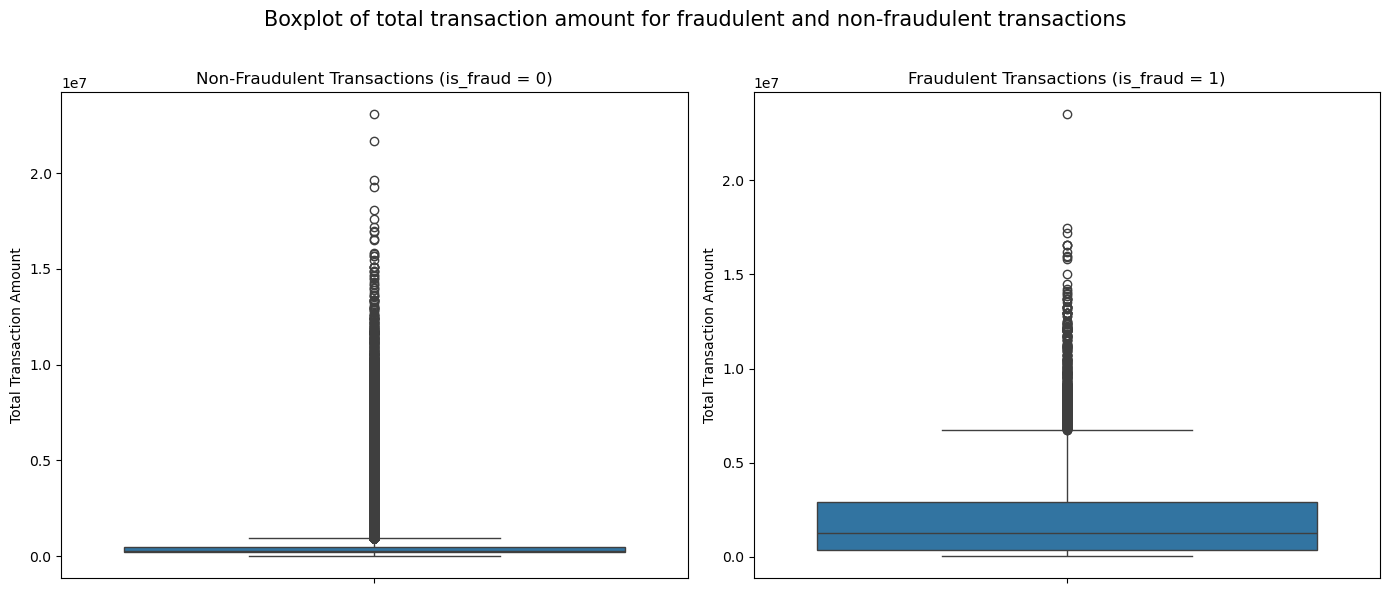

In [16]:
# Convert the feature_df to Pandas for plotting if it's a PySpark DataFrame
pandas_df = feature_df.toPandas()

# Split the data into non-fraudulent and fraudulent
non_fraud_df = pandas_df[pandas_df['is_fraud'] == False]
fraud_df = pandas_df[pandas_df['is_fraud'] == True]

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for non-fraudulent transactions (is_fraud = 0)
sns.boxplot(y="total_amount", data=non_fraud_df, ax=axes[0])
axes[0].set_title("Non-Fraudulent Transactions (is_fraud = 0)")
axes[0].set_ylabel("Total Transaction Amount")

# Plot for fraudulent transactions (is_fraud = 1)
sns.boxplot(y="total_amount", data=fraud_df, ax=axes[1])
axes[1].set_title("Fraudulent Transactions (is_fraud = 1)")
axes[1].set_ylabel("Total Transaction Amount")

# Set the main title for both subplots
fig.suptitle("Boxplot of total transaction amount for fraudulent and non-fraudulent transactions", fontsize= 15)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


### Non-Fraudulent Transactions (is_fraud = 0):
- Most non-fraudulent transactions are clustered at lower amounts, with a few outliers exceeding 1.5 to 2 million. The interquartile range (IQR) is tight, indicating little variation, and large transactions are rare.

### Fraudulent Transactions (is_fraud = 1):
- Fraudulent transactions also have outliers, but with a wider IQR, showing greater variability. The median amount is notably higher than in non-fraudulent transactions, indicating fraud often involves larger amounts.

### Overall:
- Both fraudulent and non-fraudulent transactions exhibit outliers, but fraudulent transactions show a greater spread and higher median transaction amounts.
- Non-fraudulent transactions are generally smaller, but there are significant outliers that skew the distribution upwards.


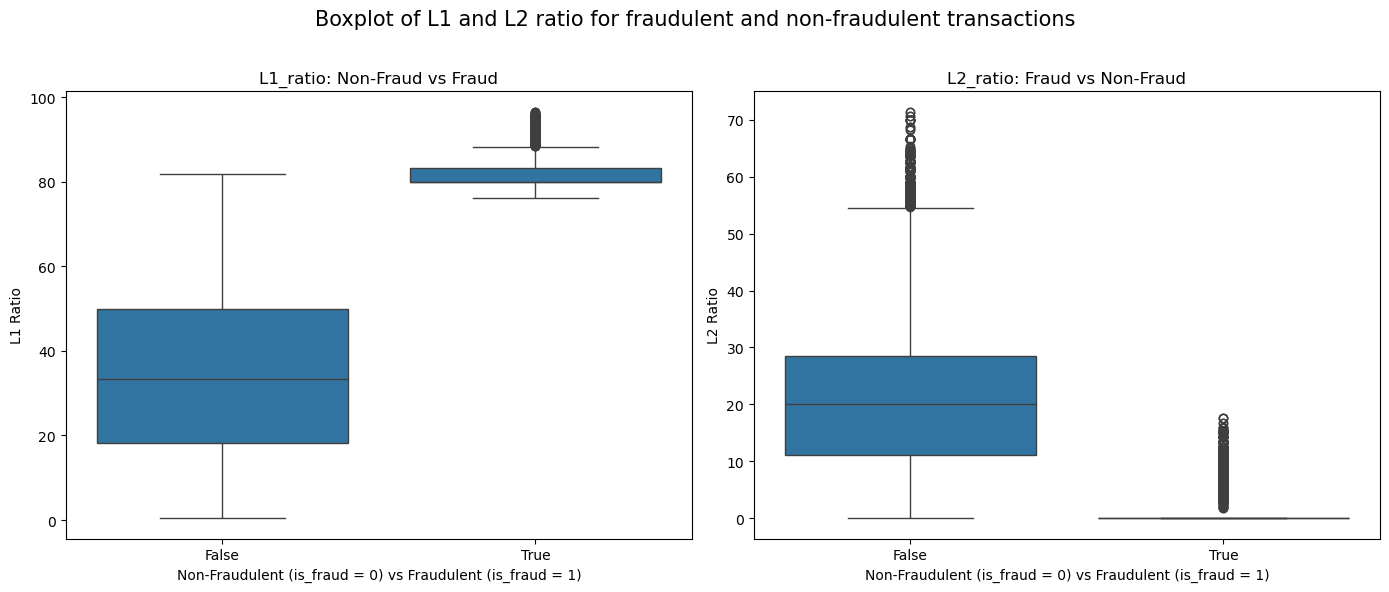

In [17]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for L1_ratio with fraud and non-fraud distinction
sns.boxplot(x="is_fraud", y="L1_ratio", data=pandas_df, ax=axes[0])
axes[0].set_title("L1_ratio: Non-Fraud vs Fraud")
axes[0].set_xlabel("Non-Fraudulent (is_fraud = 0) vs Fraudulent (is_fraud = 1)")
axes[0].set_ylabel("L1 Ratio")

# Boxplot for L2_ratio with fraud and non-fraud distinction
sns.boxplot(x="is_fraud", y="L2_ratio", data=pandas_df, ax=axes[1])
axes[1].set_title("L2_ratio: Fraud vs Non-Fraud")
axes[1].set_xlabel("Non-Fraudulent (is_fraud = 0) vs Fraudulent (is_fraud = 1)")
axes[1].set_ylabel("L2 Ratio")

# Set the main title for both subplots
fig.suptitle("Boxplot of L1 and L2 ratio for fraudulent and non-fraudulent transactions", fontsize= 15)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
plt.show()

### Non-Fraudulent Transactions (is_fraud = 0):
#### L1 Ratio:

- Non-Fraudulent Transactions: Median around 40 with a wider range (IQR 20-60), showing more variability.
- Fraudulent Transactions: Higher median around 80 with a tighter IQR, indicating more consistent L1 ratios and less variability.
#### L2 Ratio:
- Non-Fraudulent Transactions: Median around 20, with a wider distribution (IQR 10-30) and several outliers above 60.
- Fraudulent Transactions: Very low median near 0, with a small IQR and most transactions clustered at the lower end.

### Overall:
- L1 Ratio: Fraudulent transactions have a much higher and more consistent L1 ratio compared to non-fraudulent transactions, which show more variability.
- L2 Ratio: Non-fraudulent transactions have a wider spread and higher median L2 ratio, while fraudulent transactions cluster near 0, with some outliers.

This suggests that fraudulent transactions tend to have higher L1 ratios and much lower L2 ratios, making these features potential indicators of fraudulent activity.


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
300 words max for the discussion
Please only use the provided data for model building
You can create/add additional features based on the dataset
Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns

In [18]:
from pyspark.sql.functions import corr

# List of features to calculate correlation with is_fraud
features = [
    "L1_count", 
    "L2_count", 
    "L3_count",
    "L1_ratio",
    "L2_ratio",
    "age",
    "shipment_location_lat",
    "shipment_location_long",
    "first_join_year",
    "num_trans"
]

# Convert label into 0 and 1 for classification
feature_transform_df = feature_df.withColumn("label", when(col("is_fraud") == True, 1).otherwise(0)).drop("is_fraud")



In [19]:
# Calculate correlation between each feature and 'is_fraud'
correlations = {}
for feature in features:
    correlation_value = feature_transform_df.select(corr(feature, "label")).collect()[0][0]
    correlations[feature] = correlation_value

# Convert the correlations dictionary to a Pandas DataFrame for better viewing
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Feature", "Correlation_with_is_fraud"])

# Show the correlation DataFrame
correlation_df

,Feature,Correlation_with_is_fraud
0,L1_count,0.229506
1,L2_count,-0.094723
2,L3_count,-0.086468
3,L1_ratio,0.327428
4,L2_ratio,-0.172640
5,age,-0.000508
6,shipment_location_lat,-0.000458
7,shipment_location_long,0.001760
8,first_join_year,-0.009753
9,num_trans,-0.022609


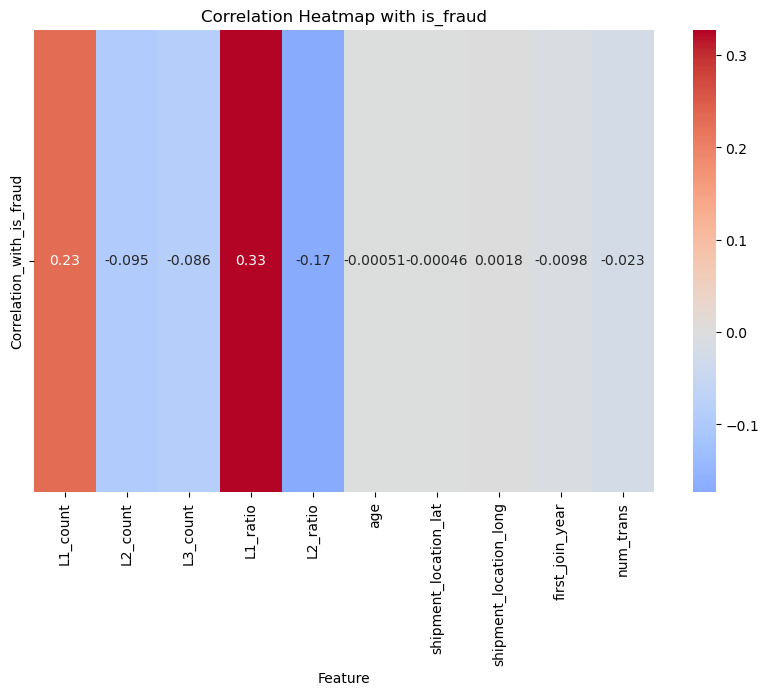

In [20]:
# Create a heatmap for correlation visualization of above features
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.set_index("Feature").T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap with is_fraud")
plt.show()

### Feature selection and transformation discussion from correlation chart and domain knowledge
**1. Removing Irrelevant Features**

Certain features in the dataset do not contribute to fraud detection and should be excluded:
- **Personal Identifiers:** Features such as first_name, last_name, username, gender and email do not provide valuable insights into fraud detection and can be safely removed.
- **Session Identifiers:** session_id is merely an identifier for tracking sessions and does not offer any predictive value, so it should also be excluded from the model.

**2. Key Features for Fraud Detection**

Several features stand out as critical for identifying fraud:
- **total_amount:** Fraudulent transactions often involve unusual amounts, making this feature crucial. Scaling may be required to standardize the values.
- **payment_method:** Different payment methods could have varying fraud risks, making this an important categorical feature. One-hot encoding will help incorporate this feature into the model.
- **promo_amount:** Fraudsters often exploit promotions or discounts, so retaining this feature is important for detecting unusual behaviors.
- **shipment_location_lat** and **shipment_location_long:** These features can indicate geographic anomalies. Transforming them into distance metrics could reveal geographic patterns related to fraud.
- **time_of_day_medium:** Time-of-day patterns may correlate with fraud occurrences, making this a useful feature for temporal analysis.
- **age** and **first_join_year:** These features can help analyze fraud risk based on user demographics, as different age groups or account ages may have varying fraud vulnerabilities.
- **L1_count, L2_count, L3_count, L1_ratio, L2_ratio, num_trans:** These features reflect behavioral patterns across multiple levels and should be retained for more granular fraud detection. According to the heatmap, L1_ratio shows the strongest positive correlation with fraud (0.33), while L1_count also exhibits a positive correlation (0.23), indicating their importance in detecting fraudulent activity. Conversely, L2_ratio (-0.17) and other level-based features show slight negative correlations, which could help differentiate non-fraudulent transactions.

**3. Feature Transformations**

- **Scaling:** Features like total_amount and promo_amount should be scaled to prevent large values from dominating the model.
- **One-Hot Encoding:** Categorical features such as payment_method and gender should be one-hot encoded for better model integration.




2.1.2 Write code to create/transform the columns based on your discussion above
Hint: You can use one data frame for both use cases (classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 

In [21]:
feature_df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: float (nullable = true)
 |-- session_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- promo_amount: float (nullable = true)
 |-- promo_code: string (nullable = true)
 |-- shipment_fee: float (nullable = true)
 |-- shipment_location_lat: float (nullable = true)
 |-- shipment_location_long: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- clear_payment: boolean (nullable = true)
 |-- ATC_count: long (nullable = false)
 |-- SER_count: long (nullable = false)
 |-- L1_count: long (nullable = true)
 |-- L2_count: long (nullable = true)
 |-- L3_count: long (nullable = true)
 |-- L1_ratio: double (nullable = true)
 |-- L2_ratio: double (nullable = true)
 |-- time_of_day_medium: string (nullable = true)
 |-- gender: string (nullable = tr

In [22]:
# Define numerical and categorical features
numerical_features = ["total_amount", "promo_amount", "shipment_fee", "shipment_location_lat", "shipment_location_long", "age", "first_join_year", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "num_trans"]
categorical_features = ["time_of_day_medium", "payment_method"] #, "gender"]

# Step 3: Create StringIndexer for categorical features to convert them into numeric indexes
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_features]

# Step 4: Create OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_features]

# Step 5: VectorAssembler to combine both numerical and encoded categorical features into a single vector column
assembler = VectorAssembler(
    inputCols=[col+"_vec" for col in categorical_features] + numerical_features,
    outputCol="features"
)

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
# Step 5: Create the Random Forest Estimator
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=77)

# Step 6: Create the Gradient-Boosted Tree Estimator
gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=77)

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [24]:
# Step 5: Create the pipeline for Random Forest
pipeline_rf = Pipeline(stages=indexers + encoders + [assembler, rf])

# Step 6: Create the pipeline for Gradient-Boosted Tree
pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler, gbt])


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset) and do a train/test split or use one year of data for training and another year for testing. 

In [25]:
# Use stratified split for 50% of the data
sampled_df = feature_transform_df.sampleBy("label", fractions={0: 0.5, 1: 0.5}, seed=77)

In [26]:
# Split the sampled data into 80% training and 20% testing
train_df, test_df = sampled_df.randomSplit([0.8, 0.2], seed=0)

# Show the sizes of train and test datasets
print(f"Training set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")

Training set size: 263339
Test set size: 65498


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [27]:
# Train the Random Forest model on the training data
model_rf = pipeline_rf.fit(train_df)

# Predict on the test data using the trained Random Forest model
predictions_rf = model_rf.transform(test_df)

# Show predictions of predictions_rf
predictions_rf.select("features", "label", "prediction").show(5)



+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[1.0,0.0,0.0,0.0,...|    0|       0.0|
|(20,[4,7,8,9,10,1...|    1|       1.0|
|[1.0,0.0,0.0,0.0,...|    0|       0.0|
|(20,[7,8,9,10,11,...|    0|       0.0|
|(20,[1,7,9,10,11,...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



In [28]:
# Train the Gradient-Boosted Tree model on the training data
model_gbt = pipeline_gbt.fit(train_df)

# Predict on the test data using the trained Gradient-Boosted Tree model
predictions_gbt = model_gbt.transform(test_df)

# Show predictions of predictions_gbt
predictions_rf.select("features", "label", "prediction").show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[1.0,0.0,0.0,0.0,...|    0|       0.0|
|(20,[4,7,8,9,10,1...|    1|       1.0|
|[1.0,0.0,0.0,0.0,...|    0|       0.0|
|(20,[7,8,9,10,11,...|    0|       0.0|
|(20,[1,7,9,10,11,...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



2.4.2 For both models (RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using PySpark MLlib/ML APIs.
Draw a ROC plot.
Discuss which one is the better model (no word limit; please keep it concise)

In [29]:
def confusion_matrix(df_prediction):
    # True / False means the prediction. Positve / Negaive means the correction with label
    # Calculate the elements of the confusion matrix
    TN = df_prediction.filter('prediction = 0 AND label = 0').count()
    TP = df_prediction.filter('prediction = 1 AND label = 1').count()

    FN = df_prediction.filter('prediction = 0 AND label = 1').count() 
    FP = df_prediction.filter('prediction = 1 AND label = 0').count()

    # Show confusion matrix
    df_prediction.groupBy('label', 'prediction').count().show()

    # Calculate metrics by the confusion matrix
    accuracy = (TP + TN) / (TP + TN + FP + FN)  # (True Positives + True Negatives) / Total
    precision = TP / (TP + FP)  # True Positives / (True Positives + False Positives)
    recall = TP / (TP + FN)     # True Positives / (True Positives + False Negatives)
    f1 = 2 * (precision * recall) / (precision + recall)  # Harmonic mean of precision and recall

    # Display the various metrics calculated above
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\n")

# Print the confusion matrix
print(f"Confusion Matrix of rf:", '\n')
confusion_matrix(predictions_rf)
print(f"Confusion Matrix of gbt:", '\n')
confusion_matrix(predictions_gbt)

Confusion Matrix of rf: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|64332|
|    1|       1.0| 1130|
|    0|       1.0|   34|
|    1|       0.0|    2|
+-----+----------+-----+

Accuracy: 0.9995
Precision: 0.9708
Recall: 0.9982
F1-Score: 0.9843


Confusion Matrix of gbt: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|64360|
|    1|       1.0| 1132|
|    0|       1.0|    6|
+-----+----------+-----+

Accuracy: 0.9999
Precision: 0.9947
Recall: 1.0000
F1-Score: 0.9974




In [30]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_rf = evaluator.evaluate(predictions_rf)

# Print AUC for the Random Forest model
print(f"Area Under ROC (Random Forest): {auc_rf}")

Area Under ROC (Random Forest): 0.9999408198850457


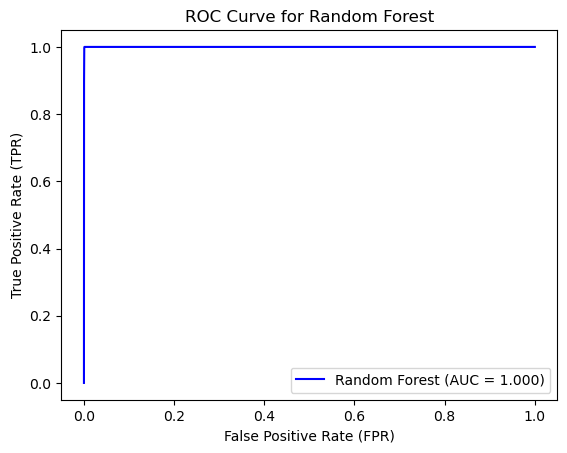

In [31]:
# Get ROC metrics from the model's summary
training_summary_rf = model_rf.stages[-1].summary 
roc_rf = training_summary_rf.roc.toPandas()

# Plot ROC curve
plt.plot(roc_rf['FPR'], roc_rf['TPR'], color='blue', label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [32]:
# Evaluate model with BinaryClassificationEvaluator for AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_gbt = evaluator.evaluate(predictions_gbt)

# Print the AUC of GBT
print(f"Area Under ROC (GBT): {auc_gbt}")

Area Under ROC (GBT): 0.9999984834409318


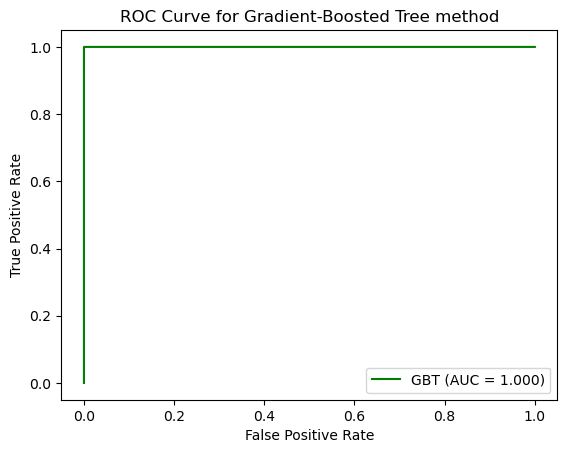

In [33]:
# Convert 'probability' column from vector to array and extract positive class probability
predictions_gbt = predictions_gbt.withColumn('probability_array', vector_to_array('probability')) \
                                 .withColumn('prob_positive', col('probability_array')[1])

# Collect the data
prob_labels = predictions_gbt.select('prob_positive', 'label').toPandas()

fpr, tpr, thresholds = roc_curve(prob_labels['label'], prob_labels['prob_positive'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', label=f'GBT (AUC = {roc_auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient-Boosted Tree method')
plt.legend(loc="lower right")
plt.show()

### Justification
Based on the confusion matrices and evaluation metrics, here is a comparison of the Random Forest (RF) and Gradient Boosted Trees (GBT) models. Note that both models were run using 50% of the dataset using stratified split, and different random seeds were tried to ensure robustness.
#### Comparison:
Based on confusion matrix:
- Accuracy: GBT has slightly higher accuracy (0.9995) compared to RF (0.9999), though both models perform exceptionally well.
- Precision: GBT outperforms RF with a precision of 0.9708 vs. RF's 0.9947, meaning GBT has fewer false positives (FP).
- Recall: GBT has perfect recall (1.0000), identifying all positive cases, while RF has a recall of 0.9982.
- F1-Score: GBT has a higher F1-Score (0.9974) than RF (0.9843), indicating a better balance between precision and recall.

*Robustness:* Both models were run on 50% of the dataset, and different random seeds were tested to ensure that the performance was not biased or overly dependent on a particular seed. This adds robustness to the results, showing that the Gradient Boosted Trees model consistently outperforms Random Forest across seeds.
#### Conclusion:
Gradient Boosted Trees (GBT) is the better model overall. It has the highest accuracy, precision, recall, and F1-Score. GBT's ability to perfectly detect all positive cases (recall = 1.0000) while maintaining very few false positives (precision = 0.9947) makes it more reliable in practice. The use of 50% of the dataset and testing with different seeds further supports the robustness of these results, reinforcing GBT as the superior choice for this task.

2.4.3 Save the better model (you need it for Part B of Assignment 2).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

Given that the GBT model demonstrates high accuracy and has been tested with a 50% data sample using a stratified split, I conclude that GBT is the best model and will proceed to save it.

In [34]:
best_model = model_gbt 

# Save model into A2B/best_model
model_path = "../A2B/best_model"

# Save the model and overwrite if the path already exists (in case running this file multiple time)
best_model.write().overwrite().save(model_path)

print(f"Model saved at: {model_path}")


Model saved at: ../A2B/best_model


### Part 3. Customer Clustering and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

Firstly, I will try to calculate main features (L1, L2 and their ratio, number of successful / fail trans), average ATC, total payment amount and number of fail transactions aggregate by customer level before putting into K-mean clustering

In [35]:
from pyspark.sql.functions import col, mean

# Perform the aggregation by customer_id with some metrics before putting K-mean clustering
customer_trans_kmean_agg = feature_transform_df.groupBy("customer_id").agg(
    F.count("transaction_id").alias("num_trans"),
    F.count(F.when(F.col("payment_status") == "Success", True)).alias("num_success_trans"),
    F.count(F.when(F.col("payment_status") == "Fail", True)).alias("num_failed_trans"),
    F.sum(F.when(F.col("payment_status") == "Success", F.col("total_amount"))).alias("total_success_amount"),
    F.sum(F.when(F.col("payment_status") == "Fail", F.col("total_amount"))).alias("total_failed_amount"),
    
    F.mean("total_amount").alias("mean_total_amount"),
    F.mean(F.when(F.col("payment_status") == "Success", F.col("total_amount"))).alias("mean_success_amount"),
    F.mean(F.when(F.col("payment_status") == "Fail", F.col("total_amount"))).alias("mean_failed_amount"),
    
    F.mean("L1_count").alias("mean_L1_count"),
    F.mean("L2_count").alias("mean_L2_count"),
    
    F.sum("L1_count").alias("total_L1_count"),
    F.sum("L2_count").alias("total_L2_count"),
    F.sum("L3_count").alias("total_L3_count"),
    (F.sum("L1_count") / (F.sum("L1_count") + F.sum("L2_count") + F.sum("L3_count"))).alias("cus_L1_ratio"),
    (F.sum("L2_count") / (F.sum("L1_count") + F.sum("L2_count") + F.sum("L3_count"))).alias("cus_L2_ratio"),
    F.sum("ATC_count").alias("total_ATC_count"),
    F.sum("SER_count").alias("total_SER_count"),
    
    F.mean("ATC_count").alias("mean_ATC_count"),
    F.max("label").alias("is_fraud_all_time"),
)

# Join customer_df with df_transactions to add gender, age, geolocation, and first_join_year to feature_df
df_customer_kmean = df_customer.join(customer_trans_kmean_agg, on="customer_id", how="inner")
df_customer_kmean.show(5)

+-----------+----------+---------+--------------------+--------------------+------+-------------------+-------------------+---+---------------+---------+-----------------+----------------+--------------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+--------------+--------------+--------------+-------------------+-------------------+---------------+---------------+------------------+-----------------+
|customer_id|first_name|last_name|            username|               email|gender|          birthdate|    first_join_date|age|first_join_year|num_trans|num_success_trans|num_failed_trans|total_success_amount|total_failed_amount|mean_total_amount|mean_success_amount|mean_failed_amount|     mean_L1_count|     mean_L2_count|total_L1_count|total_L2_count|total_L3_count|       cus_L1_ratio|       cus_L2_ratio|total_ATC_count|total_SER_count|    mean_ATC_count|is_fraud_all_time|
+-----------+----------+---------+--------

Number of clusters: 2, Silhouette Score: 0.3271126990774666
Number of clusters: 3, Silhouette Score: 0.39961751626571207
Number of clusters: 4, Silhouette Score: 0.3542053550971566
Number of clusters: 5, Silhouette Score: 0.38541209701873697
Number of clusters: 6, Silhouette Score: 0.35056560540580456
Number of clusters: 7, Silhouette Score: 0.32954737877284135
Number of clusters: 8, Silhouette Score: 0.2658021207420838
Number of clusters: 9, Silhouette Score: 0.35343881385714104


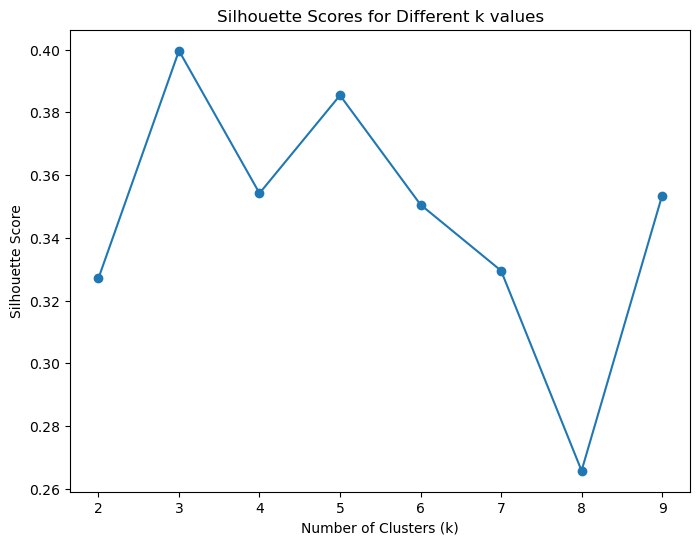

In [36]:
from pyspark.sql.functions import col, mean
from pyspark.sql.types import DoubleType
# Ensure that the required columns are of DoubleType
cols = [
    "mean_L1_count", "mean_L2_count", "cus_L1_ratio", "cus_L2_ratio",  "num_failed_trans" , "mean_ATC_count",
    "mean_total_amount"
]

for c in cols:
    df_customer_kmean = df_customer_kmean.withColumn(c, col(c).cast(DoubleType()))

# Handle null values by dropping rows with nulls in the selected columns
df_customer_kmean = df_customer_kmean.na.drop(subset=cols)

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled_data = assembler.transform(df_customer_kmean)

# Apply StandardScaler to standardize the feature vectors
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Define the evaluator for K-Means clustering using silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

# List to store silhouette scores for different k values
silhouette_arr = []

# Loop over different values of k (from 2 to 10) to find the optimal number of clusters
for k in range(2, 10):
    k_means = KMeans(featuresCol='scaledFeatures', k=k, seed=10)
    model = k_means.fit(scaled_data)
    predictions = model.transform(scaled_data)
    silhouette = evaluator.evaluate(predictions)
    silhouette_arr.append(silhouette)
    print(f'Number of clusters: {k}, Silhouette Score: {silhouette}')

# Visualizing the silhouette scores for different k values
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, 10), silhouette_arr, marker='o')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Different k values')
plt.show()

From the Silhouette score chart, we can see that optimal K is 3 with score around 0.4, which leads to to following fraud analysis by visualization (boxplots and bar charts) of 3 clusters

In [41]:
# Perform KMeans clustering with k=2 (based on the silhouette score)
k_means = KMeans(featuresCol='scaledFeatures', k=3, seed=10)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

# Ensure customer_id is preserved in the predictions DataFrame and rename the prediction column to avoid ambiguity
predictions = predictions.select("customer_id", F.col("prediction").alias("cluster_prediction"))

# Drop any existing 'cluster_prediction' columns in df_customer_kmean to avoid ambiguity during the join
if 'cluster_prediction' in df_customer_kmean.columns:
    df_customer_kmean = df_customer_kmean.drop('cluster_prediction')

# Add the 'cluster_prediction' (cluster assignments) back to the original DataFrame along with 'is_fraud_all_time'
df_customer_kmean = df_customer_kmean.join(predictions, on="customer_id")

# Convert the resulting PySpark DataFrame to a Pandas DataFrame
df_pandas_kmean = df_customer_kmean.select(*cols, 'cluster_prediction', 'is_fraud_all_time').toPandas()

In [42]:
df_pandas_kmean.head(10)

,mean_L1_count,mean_L2_count,cus_L1_ratio,cus_L2_ratio,num_failed_trans,mean_ATC_count,mean_total_amount,cluster_prediction,is_fraud_all_time
0,2.724138,3.827586,0.174009,0.244493,20.0,1.379310,4.927410e+05,0,0
1,3.090909,4.045455,0.192362,0.251768,13.0,1.659091,7.422704e+05,0,0
2,4.358974,2.769231,0.347648,0.220859,24.0,2.974359,5.486367e+05,0,1
3,4.734043,2.659574,0.340474,0.191278,42.0,3.276596,5.928775e+05,0,1
4,2.714286,5.233766,0.143939,0.277548,23.0,1.337662,4.559616e+05,0,0
5,5.000000,0.333333,0.576923,0.038462,0.0,3.333333,2.177455e+06,1,0
6,5.333333,2.666667,0.296296,0.148148,2.0,4.333333,9.565040e+05,1,1
7,4.547619,2.607143,0.355680,0.203911,19.0,3.142857,4.855202e+05,1,0
8,4.211538,2.865385,0.297959,0.202721,10.0,2.807692,5.080061e+05,1,1
9,4.243902,2.829268,0.297945,0.198630,47.0,2.780488,4.295649e+05,0,1


Confusion Matrix (Clusters vs Fraud):
Fraud        0     1
Cluster             
0        12234  2087
1        21624  4738
2         3419   686


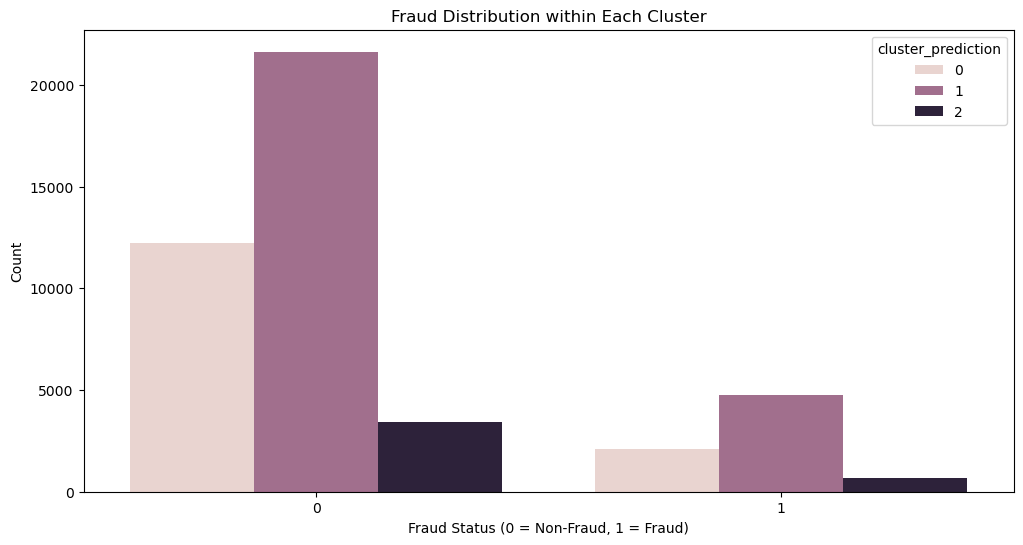

In [43]:
# Compare 'cluster_prediction' with 'is_fraud_all_time'
confusion_matrix = pd.crosstab(df_pandas_kmean['cluster_prediction'], df_pandas_kmean['is_fraud_all_time'], rownames=['Cluster'], colnames=['Fraud'])
print("Confusion Matrix (Clusters vs Fraud):")
print(confusion_matrix)

# Visualize the fraud distribution within each cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='is_fraud_all_time', hue='cluster_prediction', data=df_pandas_kmean)

# Set titles and labels
plt.title('Fraud Distribution within Each Cluster')
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')

# Show the plot
plt.show()

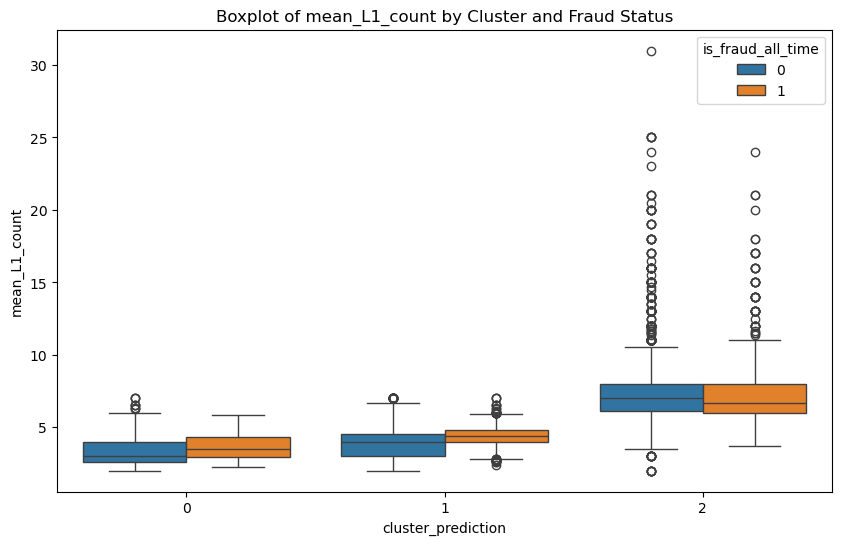

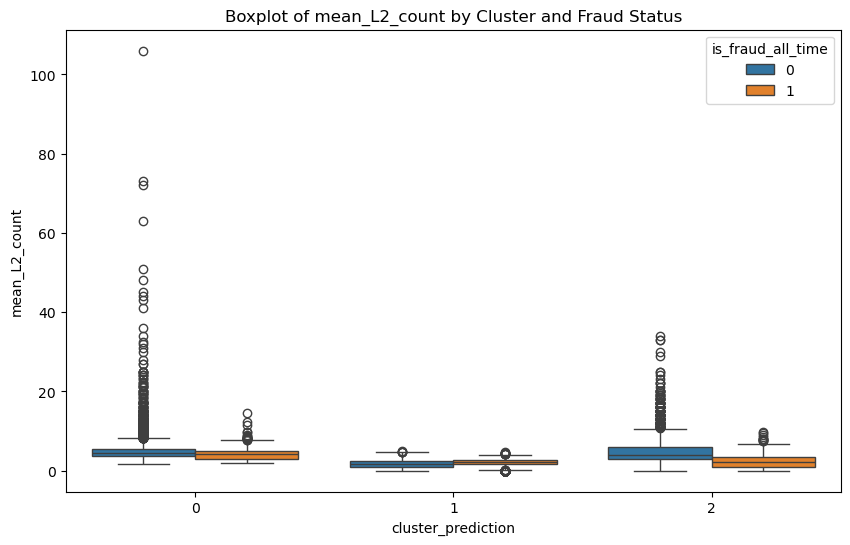

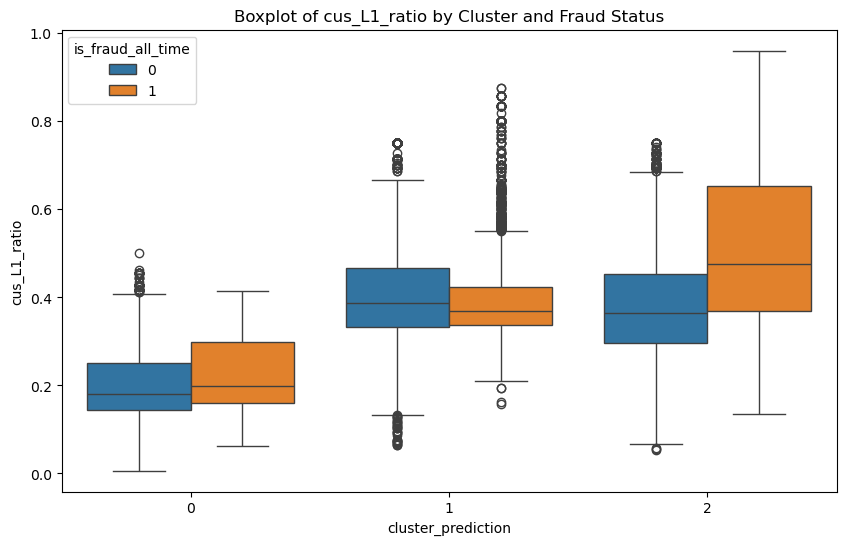

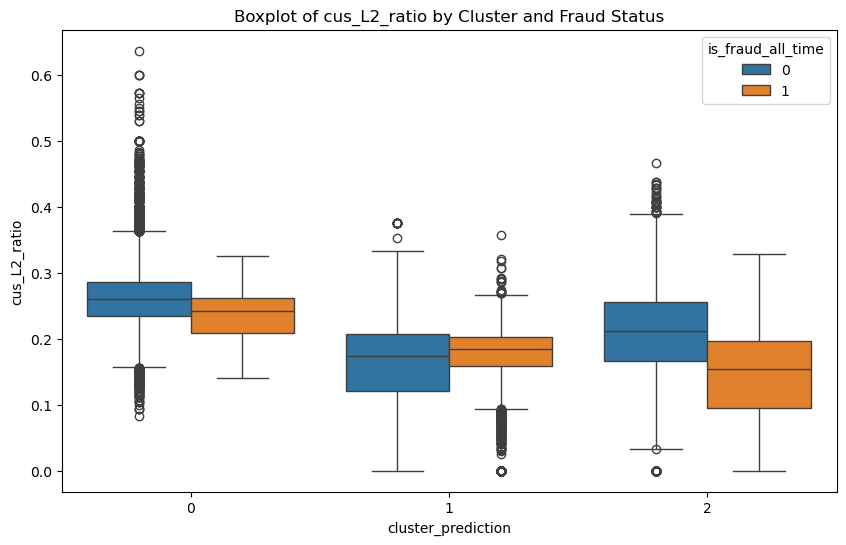

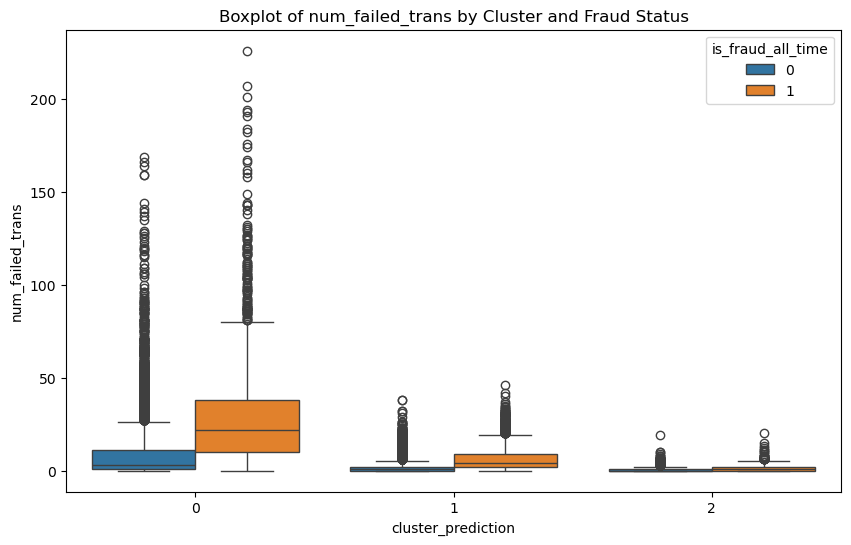

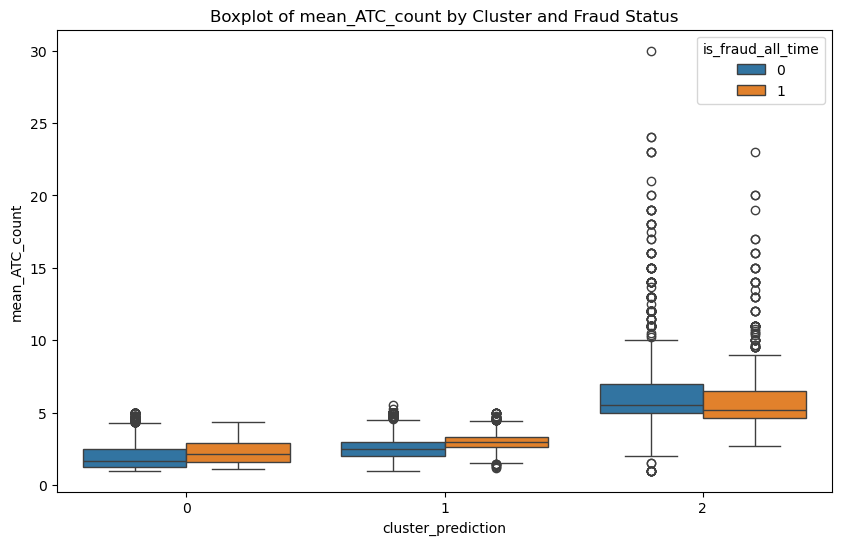

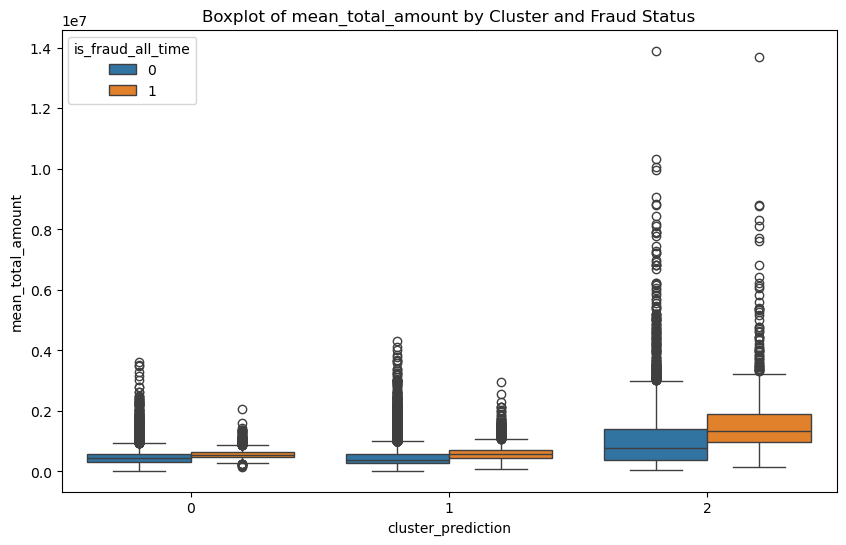

In [44]:
# Generate boxplots for each metric column based on cluster assignments and fraud status
for col in cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster_prediction', y=col, hue='is_fraud_all_time', data=df_pandas_kmean)
    plt.title(f'Boxplot of {col} by Cluster and Fraud Status')
    plt.show()

## Insights from the boxplots and confusion matrix 
Fraudster behavior varies significantly across clusters:

#### Cluster 2:
Fraudsters exhibit the most extreme behavior here. Their mean_total_amount often exceeds 0.3 million, with outliers reaching 1.4 million, compared to a median of 0.1 million for non-fraudulent users. mean_ATC_count for fraudsters has a median of around 7, with outliers reaching 30, compared to 5 for non-fraudulent users. num_failed_trans for fraudsters has a median of 5, with outliers exceeding 10. mean_L1_count shows a median of 8 for fraudsters, with some reaching up to 30, compared to 5 for non-fraudulent users. These metrics make fraudsters in this cluster more easily identifiable.

#### Cluster 0:
Fraudsters and non-fraudulent users show more overlap. mean_total_amount is similar for both groups, with a median of 0.06 million, and fraudster outliers reaching 0.2 to 0.4 million. mean_ATC_count is nearly identical, with medians around 4, and outliers reaching 7. However, num_failed_trans is a distinguishing factor: fraudsters have a median of 15, with outliers exceeding 100, while non-fraudulent users have a median of around 5. mean_L1_count is similar for both, with medians around 4-5, though fraudster outliers can reach 10.

#### Cluster 1:
Fraudsters have a mean_total_amount of around 0.05 million, with outliers up to 0.2 million. mean_ATC_count is similar for both groups, with medians around 3. Fraudsters’ num_failed_trans is low, with a median of 2, but outliers can reach 15. mean_L1_count is comparable for both groups, with medians around 5.

In summary, Cluster 2 fraudsters show the most extreme behaviors, making them easier to detect, while clusters 0 and 1 present more overlap with non-fraudulent users, making more analysis for these two clusters.

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  


## Introduction
In the era of big data, the collection of vast amounts of information from various sources raises important concerns about data ethics, privacy, and security. While big data offers many opportunities, it also brings ethical challenges. For instance, many companies collect more data than necessary, leading to questions about the ethical use of personal information. When using real-world datasets that include customer information, it is essential to address these issues responsibly.
#### Data Ethics
Data ethics ensures that data collection, storage, and processing are done responsibly, without harming individuals or society. Key ethical considerations include consent, transparency, fairness, and accountability.

###### *Influence on Big Data Processing*
- Data ethics guides companies to process data responsibly, such as by obtaining proper consent and avoiding discriminatory practices. Ethical processing prevents biased algorithms from perpetuating societal inequalities, especially in critical areas like hiring or lending.
###### *Real-World Examples*
- A positive example of ethical data use is Apple's privacy policies, which focus on anonymizing user data. On the other hand, the Cambridge Analytica scandal is a negative example, where data was misused without consent, leading to unethical political manipulation.
###### *Balancing Technology and Ethics*
- The challenge lies in balancing rapid technological advancement with ethical responsibilities. As data technologies evolve, ethical frameworks must adapt to ensure innovation does not compromise human rights or societal well-being.
## Data Privacy
Data privacy refers to the right of individuals to control how their personal information is collected, stored, and shared. In big data, privacy concerns are heightened by the vast scale of data collection and analysis.
###### *Challenges*
- Maintaining privacy is difficult, as data is often collected without users’ full understanding and can be combined with other datasets to reveal sensitive information, even when anonymized.
###### *Regulations*
- Regulations like the General Data Protection Regulation (GDPR) help protect privacy by requiring companies to obtain explicit consent and allowing individuals to request data deletion.
###### *Tools and Techniques*
- Common privacy-preserving techniques include encryption, anonymization, and differential privacy. However, these methods are not foolproof, and future improvements, such as decentralized data models using blockchain, may offer better privacy protection.
## Data Security
Data security protects data from unauthorized access, theft, and corruption, which is essential as big data grows in volume and complexity.
###### *Risks*
- Big data systems are vulnerable to cyberattacks, insider threats, and data breaches, which can cause significant financial and reputational damage.
###### *Security Measures*
- Encryption, authentication, and authorization are key tools for securing data. Encryption ensures that intercepted data cannot be read without proper decryption, while authentication and authorization control access to sensitive data. These measures must continuously evolve to counter more sophisticated attacks.
## Conclusion
Data ethics, privacy, and security are central to responsible big data processing. Ethical frameworks ensure the responsible use of data, privacy regulations safeguard individual rights, and robust security measures protect against breaches. As big data technologies advance, a balanced approach that prioritizes ethical, privacy, and security concerns is essential for ensuring that the benefits of big data are not outweighed by the risks.


#### References:
- Floridi, L. (2013). The Ethics of Information. Oxford University Press.
European Union. (2018). General Data Protection Regulation (GDPR). Retrieved from https://eur-lex.europa.eu/legal-content/en/TXT/?uri=CELEX%3A32016R0679
- Zwitter, A. (2014). Big Data Ethics. Big Data & Society, 1(2), 2053951714559253.
- Apple Privacy (n.d.). Apple’s Commitment to Privacy. Retrieved from https://www.apple.com/privacy/